## STAGE 0: VALIDATE ANNOTATED IMAGE FILES

This script assumes that a series of image files has been annotated, and that thes two folders of annotated data exist in:
- IMAGE_DIR = './annotation_workspace/images/train'
- LABEL_DIR = './annotation_workspace/labels/train'

✓ Found 2555 annotated images


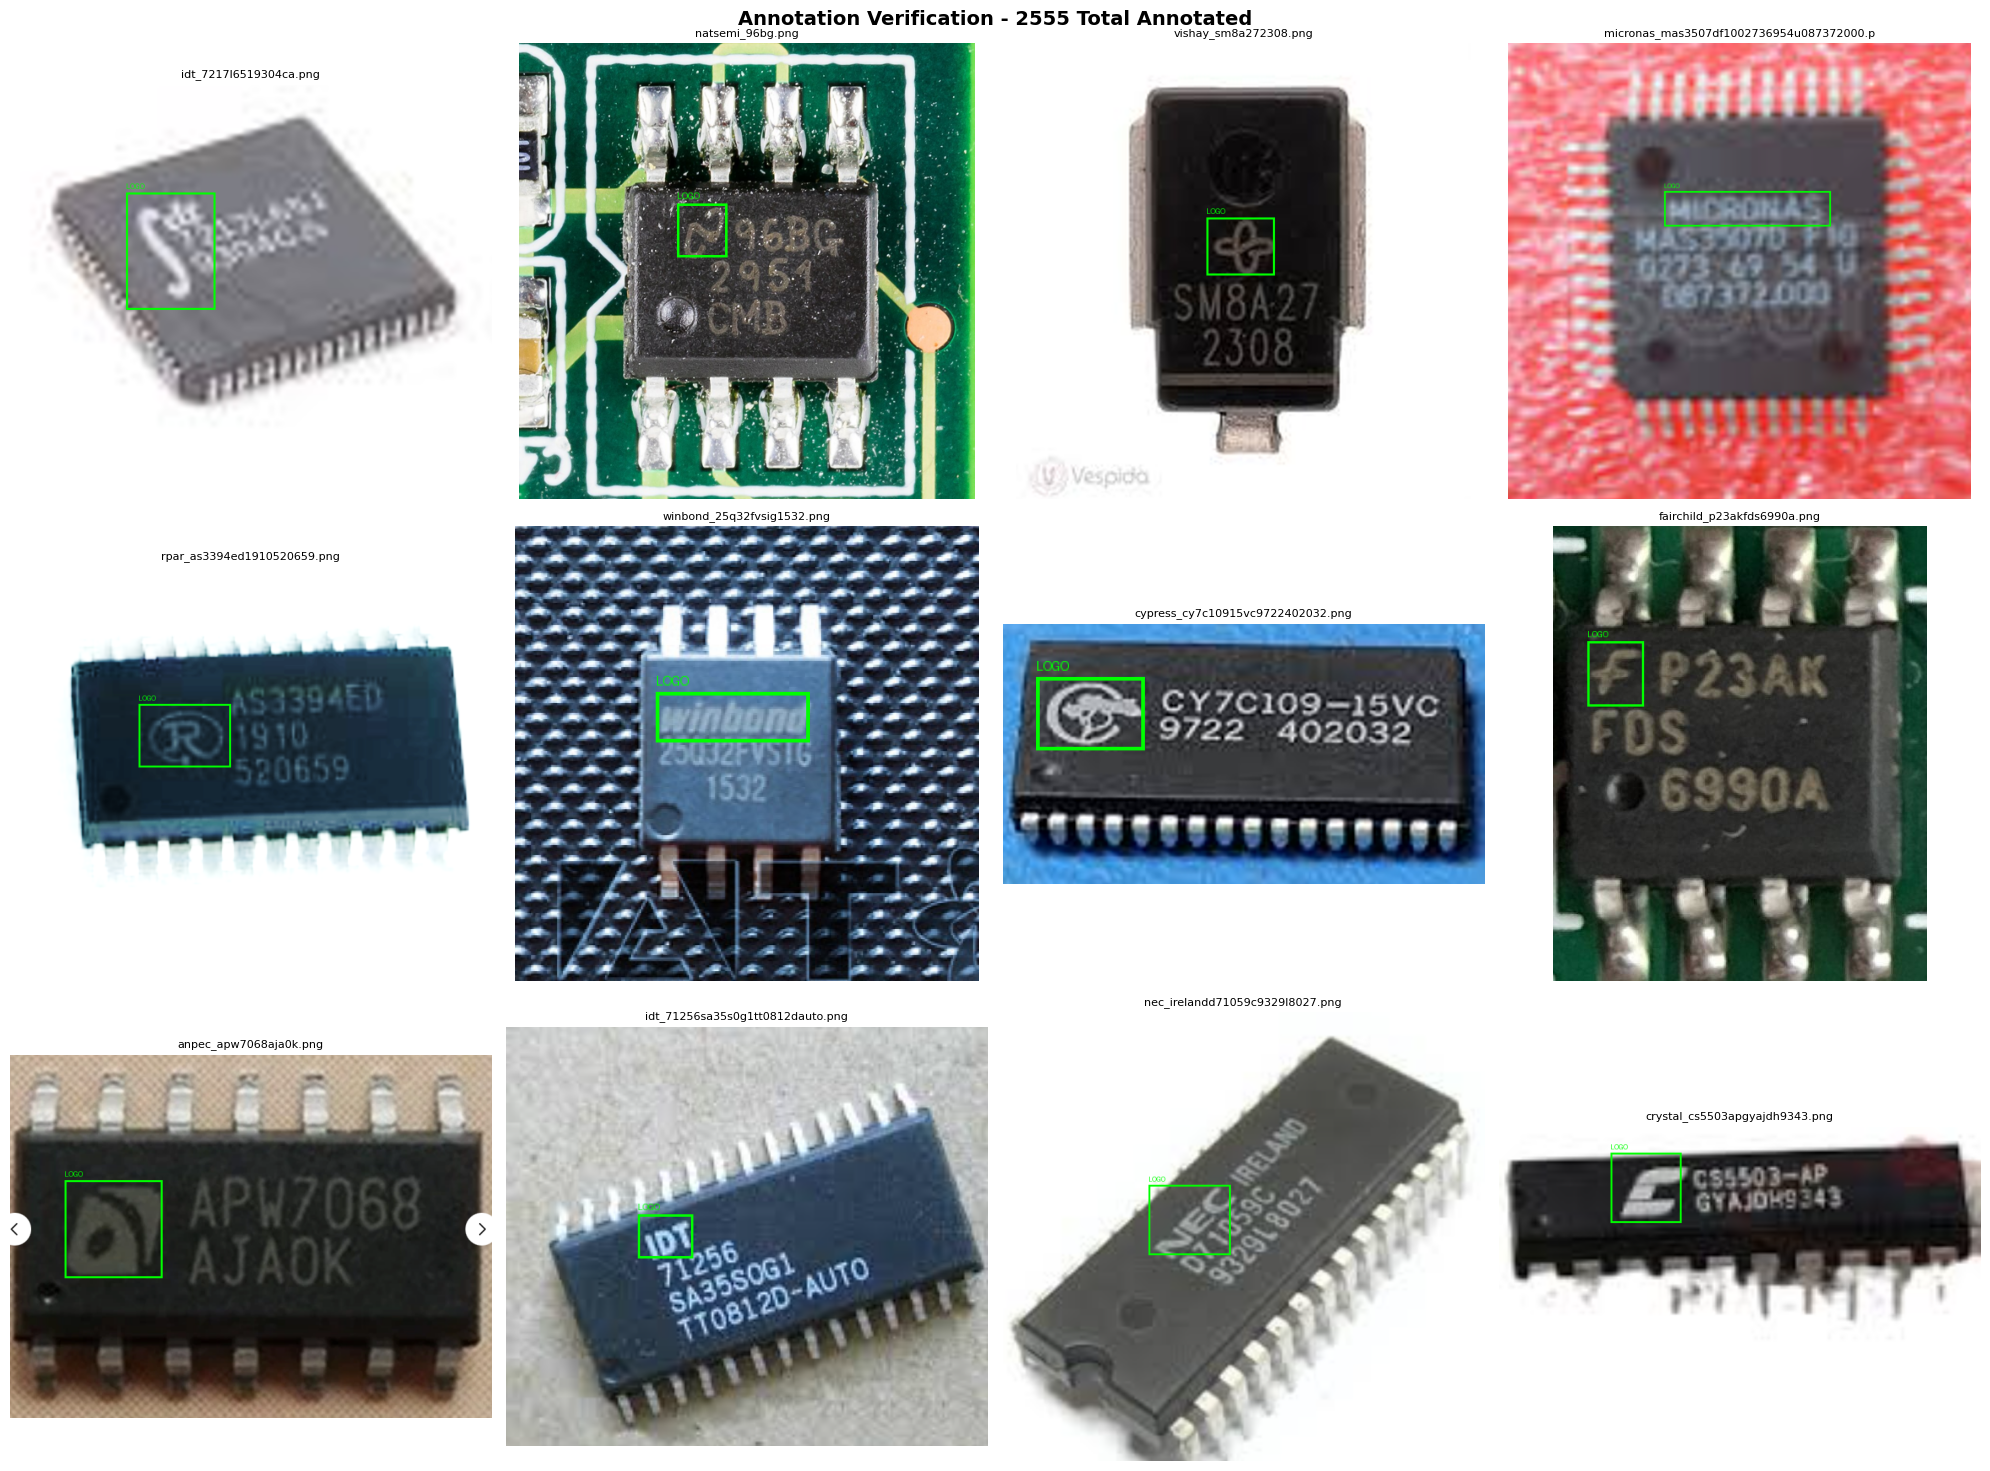


✓ Saved visualization: annotation_verification.png

ANNOTATION SUMMARY
  Total annotated: 2555
  Image dir: ./annotation_workspace/images/train
  Label dir: ./annotation_workspace/labels/train



In [1]:
# ============================================================
# VERIFY ANNOTATIONS - Visual check before training
# ============================================================

import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random

def verify_annotations(image_dir, label_dir, num_samples=12):
    """
    Visualize random annotated images to confirm boxes are correct
    """
    
    # Find all annotated images
    annotated = []
    for f in os.listdir(image_dir):
        if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            label_file = os.path.splitext(f)[0] + '.txt'
            if os.path.exists(os.path.join(label_dir, label_file)):
                annotated.append(f)
    
    print(f"✓ Found {len(annotated)} annotated images")
    
    # Random sample
    samples = random.sample(annotated, min(num_samples, len(annotated)))
    
    cols = 4
    rows = (len(samples) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 5*rows))
    axes = axes.flatten() if rows > 1 else [axes] if cols == 1 else axes.flatten()
    
    for idx, img_file in enumerate(samples):
        img = Image.open(os.path.join(image_dir, img_file)).convert('RGB')
        img_w, img_h = img.size
        draw = ImageDraw.Draw(img)
        
        # Read YOLO annotation
        label_file = os.path.splitext(img_file)[0] + '.txt'
        with open(os.path.join(label_dir, label_file), 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                
                _, xc, yc, w, h = map(float, parts)
                
                # YOLO normalized → pixel coords
                x1 = int((xc - w/2) * img_w)
                y1 = int((yc - h/2) * img_h)
                x2 = int((xc + w/2) * img_w)
                y2 = int((yc + h/2) * img_h)
                
                # Draw box
                draw.rectangle([x1, y1, x2, y2], outline='lime', width=3)
                draw.text((x1, max(0, y1-15)), 'LOGO', fill='lime')
        
        axes[idx].imshow(img)
        axes[idx].set_title(img_file[:40], fontsize=8)
        axes[idx].axis('off')
    
    # Hide unused subplots
    for idx in range(len(samples), len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle(f'Annotation Verification - {len(annotated)} Total Annotated', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('annotation_verification.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ Saved visualization: annotation_verification.png")
    return len(annotated)


# Run verification
IMAGE_DIR = './annotation_workspace/images/train'
LABEL_DIR = './annotation_workspace/labels/train'

total_annotated = verify_annotations(IMAGE_DIR, LABEL_DIR, num_samples=12)

print(f"\n{'='*60}")
print(f"ANNOTATION SUMMARY")
print(f"{'='*60}")
print(f"  Total annotated: {total_annotated}")
print(f"  Image dir: {IMAGE_DIR}")
print(f"  Label dir: {LABEL_DIR}")
print(f"{'='*60}\n")

## STAGE 1: TRAIN THE LOGO DETECTOR

This trains a Faster R-CNN model to detect logo regions. It doesn't classify manufacturers - just finds logos

In [ ]:
# ============================================================
# TRAIN STAGE 1: LOGO DETECTOR
# ============================================================
# This trains a Faster R-CNN model to detect logo regions
# It doesn't classify manufacturers - just finds logos
# ============================================================

import torch
import torch.nn as nn
from torchvision import models
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from PIL import Image
import os
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ============================================================
# Dataset for detection training
# ============================================================

class LogoDetectionDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        
        # Get annotated images only
        self.image_files = []
        for f in os.listdir(image_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
                label_file = os.path.splitext(f)[0] + '.txt'
                if os.path.exists(os.path.join(label_dir, label_file)):
                    self.image_files.append(f)
        
        print(f"  ✓ Loaded {len(self.image_files)} annotated images")
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_file = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_file)
        
        # Load image
        img = Image.open(img_path).convert('RGB')
        img_width, img_height = img.size
        img_tensor = transforms.ToTensor()(img)
        
        # Load YOLO annotation
        label_file = os.path.splitext(img_file)[0] + '.txt'
        label_path = os.path.join(self.label_dir, label_file)
        
        boxes = []
        with open(label_path, 'r') as f:
            for line in f.readlines():
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                
                _, x_center, y_center, w, h = map(float, parts)
                
                # YOLO → pixel coordinates
                x_min = (x_center - w / 2) * img_width
                y_min = (y_center - h / 2) * img_height
                x_max = (x_center + w / 2) * img_width
                y_max = (y_center + h / 2) * img_height
                
                boxes.append([x_min, y_min, x_max, y_max])
        
        # Fallback if no boxes (shouldn't happen)
        if len(boxes) == 0:
            boxes = [[0, 0, 10, 10]]
            labels = torch.zeros(1, dtype=torch.int64)
        else:
            # All logos are class 1 (0 = background, handled internally)
            labels = torch.ones(len(boxes), dtype=torch.int64)
        
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros(len(boxes), dtype=torch.int64)
        
        target = {
            'boxes': boxes,
            'labels': labels,
            'area': area,
            'iscrowd': iscrowd,
            'image_id': torch.tensor([idx])
        }
        
        return img_tensor, target


def collate_fn(batch):
    return tuple(zip(*batch))


# ============================================================
# Build detector model
# ============================================================

def get_detector_model():
    # Load pretrained Faster R-CNN
    model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
    
    # Replace box predictor for 2 classes (background + logo)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)
    
    return model


# ============================================================
# Train the detector
# ============================================================

def train_detector(image_dir, label_dir, num_epochs=15, batch_size=4, lr=0.005):
    """
    Train logo detection model
    
    Args:
        image_dir: Directory with images
        label_dir: Directory with YOLO annotations
        num_epochs: Training epochs
        batch_size: Batch size (keep small, detection is memory-intensive)
        lr: Learning rate
    """
    
    print(f"\n{'='*60}")
    print("TRAINING LOGO DETECTOR (Stage 1)")
    print(f"{'='*60}\n")
    
    # Load dataset
    dataset = LogoDetectionDataset(image_dir, label_dir)
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0
    )
    
    # Load model
    model = get_detector_model()
    model = model.to(device)
    
    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=0.0005)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
    
    print(f"  Dataset size: {len(dataset)}")
    print(f"  Batch size: {batch_size}")
    print(f"  Epochs: {num_epochs}")
    print(f"  Learning rate: {lr}\n")
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, (images, targets) in enumerate(dataloader):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward - returns dict of losses
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            
            # Backward
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
            
            epoch_loss += losses.item()
        
        lr_scheduler.step()
        avg_loss = epoch_loss / len(dataloader)
        
        print(f"Epoch {epoch+1:2d}/{num_epochs}: Loss = {avg_loss:.4f}")
    
    # Save model
    torch.save(model.state_dict(), 'logo_detector.pth')
    print(f"\n✓ Detector saved: logo_detector.pth")
    
    return model


# ============================================================
# RUN TRAINING
# ============================================================

detector = train_detector(
    image_dir=IMAGE_DIR,
    label_dir=LABEL_DIR,
    num_epochs=15,
    batch_size=4  # Increase to 8 if you have a beefy GPU
)

print(f"\n{'='*60}")
print("STAGE 1 COMPLETE: Logo detector trained!")
print(f"{'='*60}\n")

Using device: cuda

TRAINING LOGO DETECTOR (Stage 1)

  ✓ Loaded 2555 annotated images


Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to C:\Users\aaron/.cache\torch\hub\checkpoints\fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|███████████████████████████████████████████████████████████████████████████████| 160M/160M [00:06<00:00, 27.2MB/s]


  Dataset size: 2555
  Batch size: 4
  Epochs: 15
  Learning rate: 0.005

